# 2. Trích xuất và xử lý dữ liệu mô hình

### Thiết lập ban đầu

In [ ]:
from sklearn.model_selection import train_test_split
from statsmodels.tools.eval_measures import meanabs, mse, rmse
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import statsmodels.api as sm


pd.options.mode.copy_on_write = True
pd.options.display.max_columns = None

In [88]:
# # For Google Colab
# from google.colab import drive
# from pydrive2.auth import GoogleAuth
# from pydrive2.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Auth Google Drive
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# # Download files on Shared folder to Google Colab

# # Shared folder ID
# folder_id = "1cv2YpR9aqRwocc8jwHLcFopfV9G0S-vH"

# # File name
# needed_files = [
#     "chotot_data.csv",
#     "input_scoli_2023.json",
#     "model_ref_price_extra.csv",
#     "model_ref_price_full.csv",
#     "origin_country_multiplier.csv",
# ]

# # Search for the file in the shared folder
# file_list = drive.ListFile({'q': f"'{folder_id}' in parents"}).GetList()
# file_list_simplified = []
# if file_list:
#     for file in file_list:
#       file_name = file['title']
#       file_id = file['id']
#       if file_name in needed_files:
#         file_list_simplified.append({
#             file_name: file_id
#         })

#         # Download the file to Colab
#         downloaded = drive.CreateFile({'id': file_id})
#         downloaded.GetContentFile(file_name)

# MODEL_REF_PRICE_PATH = "model_ref_price_full.csv"
# MODEL_REF_EXTRA_PRICE_PATH = "model_ref_price_extra.csv"
# COUNTRY_MULTIPLIER_PATH = "origin_country_multiplier.csv"
# SCOLI_PATH = "input_scoli_2023.json"
# INPUT_FILE_PATH = "chotot_data.csv"


# For VSCode
MODEL_REF_PRICE_PATH = "../data/raw/model_ref_price_full.csv"
MODEL_REF_EXTRA_PRICE_PATH = "../data/raw/model_ref_price_extra.csv"
COUNTRY_MULTIPLIER_PATH = "../data/raw/origin_country_multiplier.csv"
SCOLI_PATH = "../data/raw/input_scoli_2023.json"
INPUT_FILE_PATH = "../data/raw/chotot_data.csv"

In [89]:
df = pd.read_csv(INPUT_FILE_PATH)
df.head(3)

,title,price,description,origin,location,post_time,brand,model,reg_year,mileage,condition,vehicle_type,engine_capacity,warranty,weight,url
0,Bán xe pg 1. Đã lên đồ chơi,33.000.000 đ,Xe đã lên \r\nThắng đĩa sau\r\nBánh không ruột...,Đang cập nhật,"Phường Phú Hòa, Thành phố Thủ Dầu Một, Bình Dương",Đăng 15 ngày trước,Yamaha,Dòng khác,2024,1700,Đã sử dụng,Tay côn/Moto,100 - 175 cc,Bảo hành hãng,> 50 kg,/mua-ban-xe-may-thanh-pho-thu-dau-mot-binh-duo...
1,Xe SH 150i CBS 2017-2018 màu đỏ xe còn đẹp,60.000.000 đ,Mô tả sản phẩm: Bán xe Honda SH 150i CBS 2017-...,Việt Nam,"Phường Phước Tân, Thành phố Biên Hòa, Đồng Nai",Đăng 6 giờ trước,Honda,SH,2017,10000,Đã sử dụng,Tay ga,100 - 175 cc,Bảo hành hãng,> 50 kg,/mua-ban-xe-may-thanh-pho-bien-hoa-dong-nai/12...
2,Cần bán xe Lyberty,5.200.000 đ,Nhà thừa xe nên cần bán cho ai có nhu cầu ..,Nhật Bản,"Xã Hoàng Văn Thụ, Huyện Chương Mỹ, Hà Nội",Đăng 2 giờ trước,Piaggio,Liberty,2012,500000,Đã sử dụng,Tay ga,100 - 175 cc,Bảo hành hãng,> 50 kg,/mua-ban-xe-may-huyen-chuong-my-ha-noi/1228839...


In [90]:
df.describe(include="all").head(3)
# Loại bỏ các biến condition, warranty, weight
# vehicle_type, engine_capacity là thuộc tính của mẫu xe > chỉ cần giữ lại model

,title,price,description,origin,location,post_time,brand,model,reg_year,mileage,condition,vehicle_type,engine_capacity,warranty,weight,url
count,16135,16135,16135,16135,16135,16135,16135,16135,16135,16135.0,16135,16135,16135,16135,16135,16135
unique,15025,1073,16048,11,2618,53,40,227,45,NaN,1,3,5,1,1,16081
top,Cần bán,15.000.000 đ,Mình cần bán xe như hình \r\nXe giấy tờ đầy đủ...,Việt Nam,"Phường Bình Hưng Hoà A, Quận Bình Tân, Tp Hồ C...",Đăng 2 tháng trước,Honda,Wave,2019,NaN,Đã sử dụng,Tay ga,100 - 175 cc,Bảo hành hãng,> 50 kg,/mua-ban-xe-may-thanh-pho-ba-ria-ba-ria-vung-t...


## 2.2. Tiền xử lý dữ liệu

### Làm sạch cột

In [91]:
# Giá
# Loại bỏ dấu chấm và chữ đ, chuyển thành dạng số
df["price_clean"] = pd.to_numeric(df["price"].str.replace("đ", "").str.replace(".", ""))

# Chuyển thành đơn vị nghìn đồng để số nhỏ đi, giúp dễ nhìn hơn trên biểu đồ
df["price_clean"] = df["price_clean"] / 1_000

In [92]:
# Địa điểm bán. Xử lý để chỉ giữ lại tỉnh
df["province"] = df["location"].str.split(", ").apply(lambda x: x[-1])

In [93]:
# Năm đăng ký
# Chuẩn hóa năm đăng ký bằng cách chuyển đổi sang định dạng số
# Xử lý trường hợp đặc biệt "trước năm 1980"
df["reg_year_clean"] = pd.to_numeric(
    df["reg_year"].case_when(caselist=[(df["reg_year"].eq("trước năm 1980"), 1980)])
)

### Tạo đặc trưng mới

In [94]:
# Biến đổi năm đăng ký thành biến tuổi (age) để dễ dàng hình dung độ cũ của xe
CURRENT_YEAR = 2025
df["age"] = CURRENT_YEAR - df["reg_year_clean"]

### Loại bỏ các dòng xe không rõ ràng

In [95]:
df_filter = df[~df["model"].isin(["Dòng khác", "dòng khác"])]

## 2.3. EDA các biến

### Biến phản hồi (price)

<Axes: >

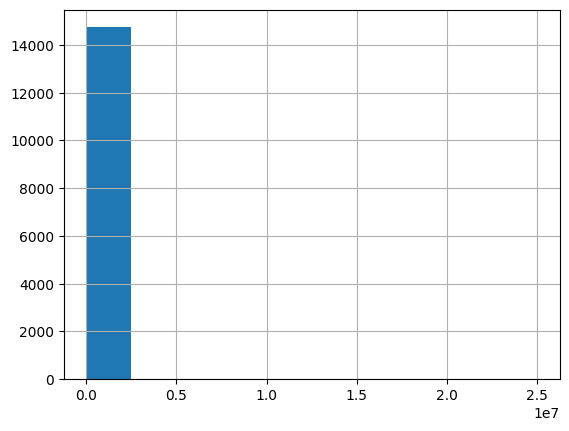

In [96]:
df_filter["price_clean"].hist()
# 1e7 = 10 triệu (nghìn đồng) = 10 tỷ

In [97]:
# Kiểm tra khoảng giá trị của biến giá
df_filter["price_clean"].sort_values()

# Giá trị vô lý: 0 đồng - 25 tỷ

704      0.000000e+00
14758    0.000000e+00
1252     0.000000e+00
8224     0.000000e+00
4761     0.000000e+00
             ...     
8719     2.900000e+06
382      7.800000e+06
12428    1.000000e+07
13928    2.480000e+07
3712     2.500000e+07
Name: price_clean, Length: 14752, dtype: float64

<Axes: >

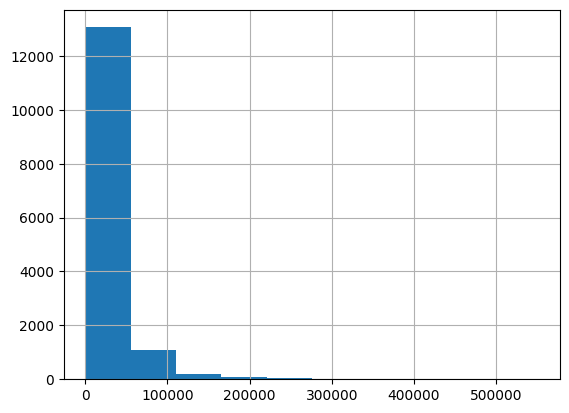

In [98]:
# Lấy khoảng giá trị hợp lý và thử lại
df_filter = df_filter[df_filter["price_clean"].between(1_000, 600_000)]
df_filter["price_clean"].hist()

# Phân phối lệch phải (đuôi bên phải nhỏ). Có thể cần biến đổi log để chuẩn hóa.

<Axes: >

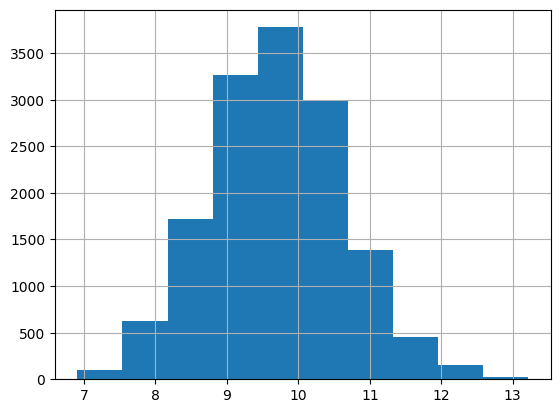

In [99]:
# Thử biến đổi log biến giá và kiểm tra histogram
df_filter["price_log"] = np.log(df_filter["price_clean"])
df_filter["price_log"].hist()

### Biến giải thích

#### Biến định lượng

###### age

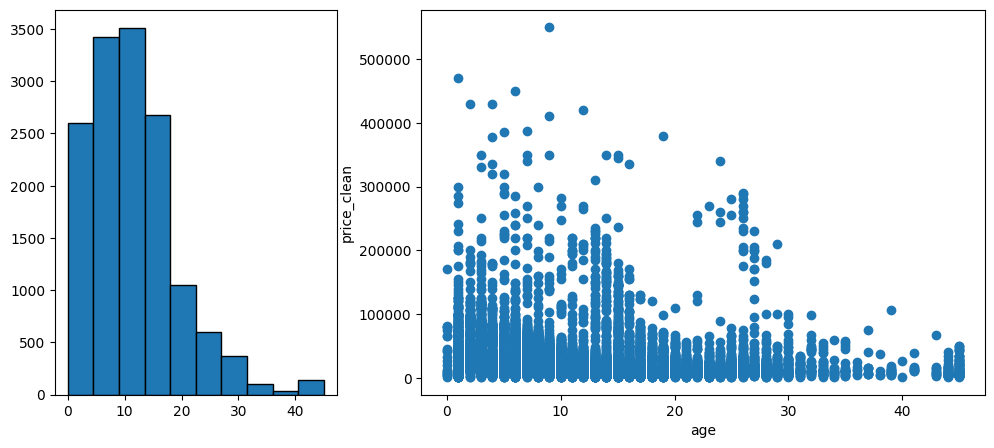

In [100]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), width_ratios=[1, 2])
ax1.hist(x="age", data=df_filter, ec="black")
ax2.scatter(x="age", y="price_clean", data=df_filter)
ax2.set_xlabel("age")
ax2.set_ylabel("price_clean")
plt.show()

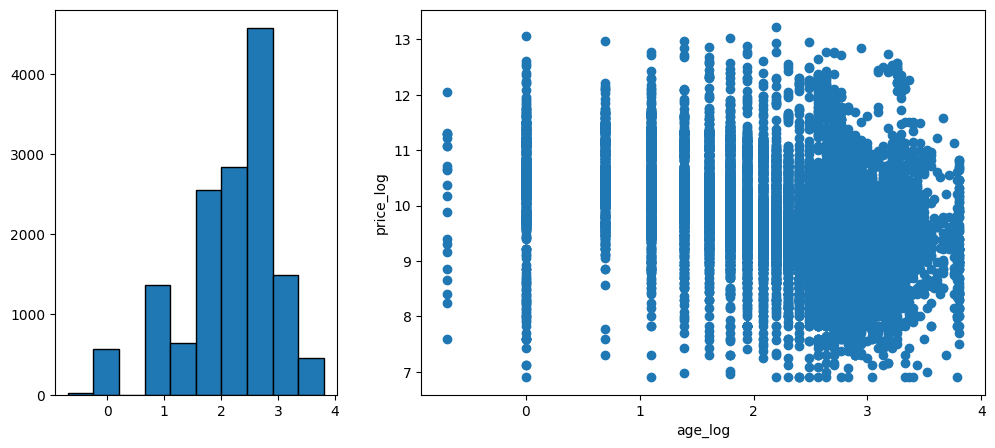

In [101]:
# Biến đổi log biến age.
# Đặt age = 0 thành age = 0.5 vì hàm log yêu cầu giá trị khác 0
# Biến đổi này hợp lý vì trong năm nay, có xe mua đầu năm, có xe mua cuối năm,
# nên ta có thể lấy tuổi trung bình là 0.5
df_filter["age_updated"] = df_filter["age"].case_when(
    caselist=[(df_filter["age"].eq(0), 0.5)]
)
df_filter["age_log"] = np.log(df_filter["age_updated"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), width_ratios=[1, 2])
ax1.hist(x="age_log", data=df_filter, ec="black")
ax2.scatter(x="age_log", y="price_log", data=df_filter)
ax2.set_xlabel("age_log")
ax2.set_ylabel("price_log")
plt.show()

###### mileage

In [102]:
df_filter["mileage"].sort_values()

7075          0
1599          0
9834          0
4645          0
14429         0
          ...  
2919     999999
6067     999999
7722     999999
12806    999999
4509     999999
Name: mileage, Length: 14517, dtype: int64

In [103]:
df_filter = df_filter[df_filter["mileage"].between(500, 900_000)]

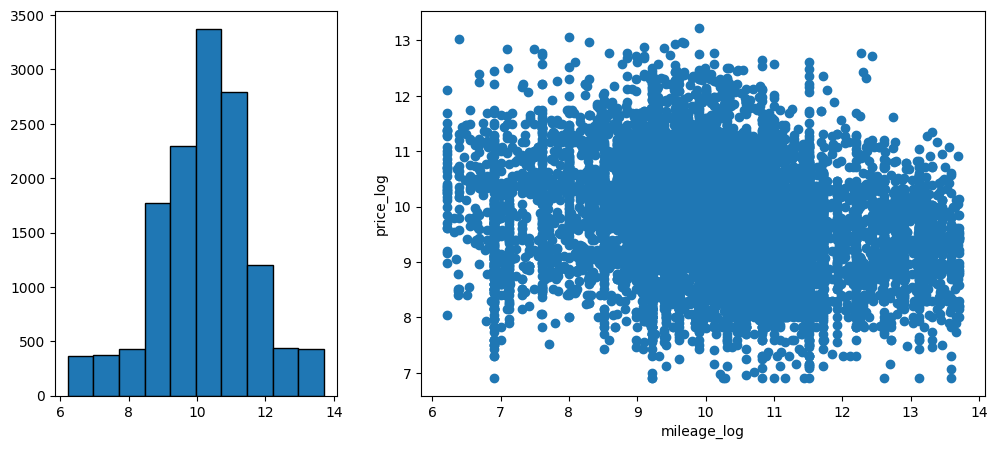

In [104]:
df_filter["mileage_log"] = np.log(df_filter["mileage"])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), width_ratios=[1, 2])
ax1.hist(x="mileage_log", data=df_filter, ec="black")
ax2.scatter(x="mileage_log", y="price_log", data=df_filter)
ax2.set_xlabel("mileage_log")
ax2.set_ylabel("price_log")
plt.show()

#### Biến định tính

##### show data

In [105]:
df_filter[["model", "origin", "province"]].head(3)

,model,origin,province
1,SH,Việt Nam,Đồng Nai
2,Liberty,Nhật Bản,Hà Nội
3,Giorno,Nhật Bản,Tp Hồ Chí Minh


chuyen doi sang dang so

##### Thêm dữ liệu

In [106]:
def transform_model(df_col: pd.Series) -> pd.Series:
    # Get reference value
    df_variants = pd.read_csv(MODEL_REF_PRICE_PATH)
    df_model_extra = pd.read_csv(MODEL_REF_EXTRA_PRICE_PATH)

    # Filter out null price
    df_variants.dropna(subset="price_min", inplace=True)

    # Get mean price
    df_variants["price_avg"] = (df_variants["price_min"] + df_variants["price_max"]) / 2

    # Get model. Resolve case with 'Air Blade'
    df_variants["model_original"] = (
        df_variants["model_name"].str.split().apply(lambda x: x[0])
    )
    df_variants["model"] = df_variants["model_original"].case_when(
        caselist=[
            (df_variants["model_name"].str.contains("Air Blade"), "Air Blade"),
            (df_variants["model_name"].str.contains("SH Mode"), "SH Mode"),
            (df_variants["model_name"].str.contains("Super Cub"), "Cub"),
            (df_variants["model_name"].str.contains("Winner X"), "Winner X"),
            (df_variants["brand_name"].eq("Vespa"), "Vespa"),
        ]
    )

    # Get average price by model
    df_model_ref_price_original = df_variants.groupby(by="model", as_index=False).agg(
        {"price_avg": "mean"}
    )
    df_model_ref_price = pd.concat([df_model_ref_price_original, df_model_extra])
    df_model_ref_price["price_avg_log"] = np.log(
        df_model_ref_price["price_avg"] * 1_000
    )

    # Join with dataframe
    df_input = df_col.to_frame()
    df_input["model"] = df_input.iloc[:, 0]

    output_df = df_input.merge(
        right=df_model_ref_price, left_on="model", right_on="model", how="left"
    )

    return (output_df["price_avg"], output_df["price_avg_log"])


def transform_origin(df_col: pd.Series) -> pd.Series:
    # Get reference value
    df_countries = pd.read_csv(COUNTRY_MULTIPLIER_PATH)

    # Join with dataframe
    df_input = df_col.to_frame()
    df_input["origin"] = df_input.iloc[:, 0]
    output_df = df_input.merge(
        right=df_countries, left_on="origin", right_on="country_name", how="left"
    )

    return output_df["country_multiplier"]


def read_json_stat(file_path: str) -> pd.DataFrame:
    """
    Read a JSON-stat file as an input and return a parsed Dataframe
    """
    with open(file_path, encoding="utf-8") as input_file:
        data = json.load(input_file)

    # Extracting the dimensions and values
    dimensions = data["dataset"]["dimension"]
    values = data["dataset"]["value"]

    # Creating a list of headers for the DataFrame
    headers = [dimensions[dim]["label"] for dim in dimensions["id"]] + ["Value"]

    # Creating a list of rows for the DataFrame
    rows = []
    for i, value in enumerate(values):
        row = []
        for dim in dimensions["id"]:
            for key, index in dimensions[dim]["category"]["index"].items():
                if index == i % dimensions["size"][dimensions["id"].index(dim)]:
                    row.append(dimensions[dim]["category"]["label"][key])
        row.append(value)
        rows.append(row)

    # Creating the DataFrame
    output_df = pd.DataFrame(rows, columns=headers)

    return output_df


def transform_province(df_col: pd.Series) -> pd.Series:
    """
    Note that the input here must be picked from the input_scoli itself,
    otherwise join will introduce nan values
    """
    # Get reference value
    df_scoli = read_json_stat(file_path=SCOLI_PATH)
    df_scoli.columns = ["province", "year", "province_scoli"]

    # Join with dataframe
    df_input = df_col.to_frame()
    df_input["province"] = df.iloc[:, 0]
    output_df = df_input.merge(
        right=df_scoli, left_on="province", right_on="province", how="left"
    )

    return output_df["province_scoli"]

In [107]:
# Clean province
df_filter["province_clean"] = df_filter["province"].case_when(
    caselist=[
        (df_filter["province"].eq("Tp Hồ Chí Minh"), "TP. Hồ Chí Minh"),
        (df_filter["province"].eq("Bà Rịa - Vũng Tàu"), "Bà Rịa-Vũng Tàu"),
        (df_filter["province"].eq("Thừa Thiên Huế"), "Thừa Thiên - Huế"),
        (df_filter["province"].eq("Thanh Hóa"), "Thanh Hoá"),
        (df_filter["province"].eq("Khánh Hòa"), "Khánh Hoà"),
        (df_filter["province"].eq("Hòa Bình"), "Hoà Bình"),
    ]
)


# Update origin from description and title
def update_origin(row):
    ORIGIN_MAPPING = {
        "Thái Lan": ["thái", "thai lan", "xe thái"],
        "Nhật Bản": ["nhật", "nhat ban", "xe nhật"],
        "Indonesia": ["indonesia", "xe indo"],
        "Ý": ["ý", "italia"],
        "Mỹ": ["mỹ", "america", "xe mỹ"],
        "Trung Quốc": ["trung", "xe tq", "xe trung quốc", "trung quốc"],
        "Ấn Độ": ["ấn", "xe ấn", "an do"],
        "Hàn Quốc": ["hàn", "xe hàn", "han quoc"],
        "Đức": ["đức", "xe đức", "duc"],
        "Đài Loan": ["đài", "xe đài", "dai loan"],
    }
    if row["origin"].lower() in ["đang cập nhật", "nước khác"]:
        text = f"{row['description']} {row['title']}".lower().strip()
        for country, keywords in ORIGIN_MAPPING.items():
            if any(re.search(rf"\b{keyword}\b", text) for keyword in keywords):
                return country
        return "Việt Nam"
    else:
        return row["origin"]


df_filter["origin_updated"] = df_filter.apply(update_origin, axis=1)

df_filter["model_ref_price_avg"], df_filter["model_ref_price_log"] = transform_model(
    df_filter["model"]
)
df_filter["origin_multiplier"] = transform_origin(df_filter["origin_updated"])
df_filter["province_scoli"] = transform_province(df_filter["province_clean"])

# Filter
## Get rows with reference price only
df_filter = df_filter[df_filter["model_ref_price_log"].notnull()]

## Models with over 30 offers only
df_model_count = df_filter.groupby("model").agg(counts=("model", "count")).reset_index()
df_model_over_n = df_model_count[df_model_count["counts"] >= 30]
df_filter = df_filter[df_filter["model"].isin(df_model_over_n["model"])]

## Remove outliers, unreasonable price. These are either
## only the bike component, or are actually another model
df_filter = df_filter[
    ~((df_filter["model"] == "SH") & (df_filter["price_clean"] < 3_000))
]

##### Xem dữ liệu mới và kiểm tra sự tuyến tính

In [108]:
df_filter[["model_ref_price_log", "origin_multiplier", "province_scoli"]].head(3)

,model_ref_price_log,origin_multiplier,province_scoli
1,10.975071,3.0,NaN
4,10.257659,2.0,NaN
5,11.695228,1.0,NaN


<Axes: xlabel='province_scoli', ylabel='price_log'>

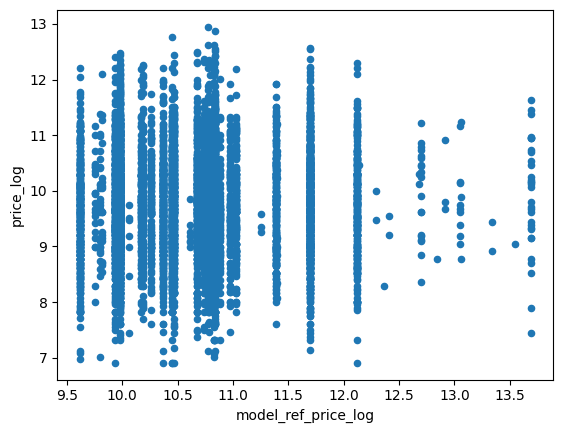

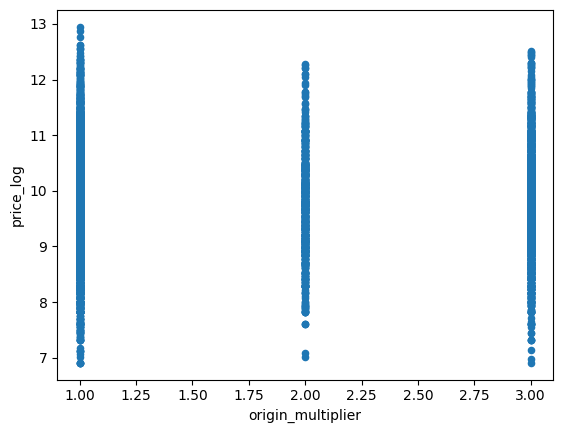

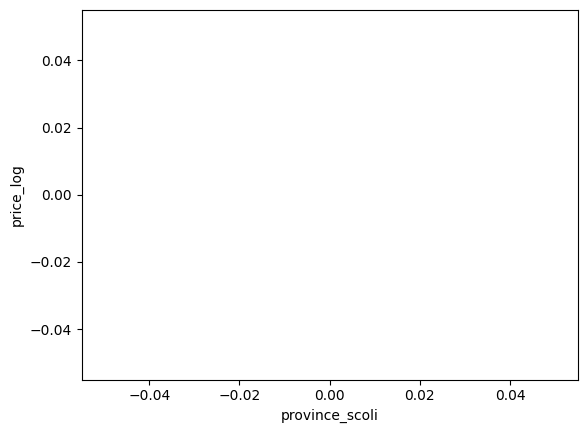

In [109]:
df_filter.plot.scatter("model_ref_price_log", "price_log")
df_filter.plot.scatter("origin_multiplier", "price_log")
df_filter.plot.scatter("province_scoli", "price_log")

# 3. Tạo mô hình

## 3.1. Các loại mô hình phù hợp (slide)

## 3.2. Mô hình hồi quy

### 3.2.1. Tạo mô hình

In [110]:
df_filter[
    [
        "age_log",
        "mileage_log",
        "origin_multiplier",
        "model_ref_price_log",
        "province_scoli",
    ]
].info()

<class 'pandas.core.frame.DataFrame'>
Index: 7831 entries, 1 to 13467
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age_log              7831 non-null   float64
 1   mileage_log          7831 non-null   float64
 2   origin_multiplier    7831 non-null   float64
 3   model_ref_price_log  7831 non-null   float64
 4   province_scoli       0 non-null      float64
dtypes: float64(5)
memory usage: 367.1 KB


In [111]:
Y = df_filter["price_log"]
X1 = sm.add_constant(
    data=df_filter[
        [
            "age_log",
            "mileage_log",
            "origin_multiplier",
            "model_ref_price_log",
            "province_scoli",
        ]
    ]
)

# Split train test data
X_train, X_test, Y_train, Y_test = train_test_split(
    X1, Y, test_size=0.20, random_state=42
)
model_1 = sm.OLS(Y_train, X_train).fit()
print(f"{model_1.summary()=}")

MissingDataError: exog contains inf or nans

## 3.2.2. Cải thiện độ chính xác

### Phân tích quan sát ngoại lai có ảnh hưởng

#### Tìm các quan sát ngoại lai có nhiều ảnh hưởng

In [ ]:
# Diagnose influential points
# Ref: https://towardsdatascience.com/linear-regression-models-and-influential-points-4ee844adac6d/
df_influence = model_1.get_influence().summary_frame()
# Join on index
df_with_influence = df_filter.join(other=df_influence, how="inner")

# Number of observations
n = len(df_influence)
# Predictors
k = 5
cutoff_leverage = ((2 * k) + 2) / n
cutoff_cooks: float = df_influence["cooks_d"].mean() * 3

# Values with high hat values / Cook distance
df_high_leverage = df_with_influence[df_with_influence["hat_diag"] >= cutoff_leverage]
df_high_cooks_d = df_with_influence[df_with_influence["cooks_d"] >= cutoff_cooks]

# High hat values / Cook distance count group by model
df_high_leverage.groupby("model")["hat_diag"].count()
df_model_high_leverage_count = (
    df_high_leverage.groupby("model")["hat_diag"]
    .count()
    .sort_values(ascending=False)
    .reset_index()
)

df_high_cooks_d.groupby("model")["cooks_d"].count()
df_model_high_cook_count = (
    df_high_cooks_d.groupby("model")["cooks_d"]
    .count()
    .sort_values(ascending=False)
    .reset_index()
)

# Count by model, joined with hat value and cook distance count
df_model_count = (
    df_with_influence.groupby("model")["price_clean"]
    .agg(counts="count")
    .sort_values(by="counts", ascending=False)
    .reset_index()
)
df_count_join = df_model_count.merge(
    right=df_model_high_leverage_count, left_on="model", right_on="model", how="left"
).merge(right=df_model_high_cook_count, left_on="model", right_on="model", how="left")
df_count_join.fillna(0, inplace=True)

# Calculate influential observation percentage
df_count_join["high_leverage_pct"] = df_count_join["hat_diag"] / df_count_join["counts"]
df_count_join["high_cook_pct"] = df_count_join["cooks_d"] / df_count_join["counts"]
df_count_join.sort_values("high_leverage_pct", ascending=False).head(10)

,model,counts,hat_diag,cooks_d,high_leverage_pct,high_cook_pct
21,Sport / Xipo,74,12.0,27.0,0.162162,0.364865
4,Dream,271,35.0,43.0,0.129151,0.158672
28,67,48,6.0,5.0,0.125000,0.104167
13,Cub,163,17.0,18.0,0.104294,0.110429
16,SH Mode,96,10.0,0.0,0.104167,0.000000
25,Satria,49,5.0,0.0,0.102041,0.000000
8,Vario,212,21.0,7.0,0.099057,0.033019
30,Grande,43,4.0,1.0,0.093023,0.023256
36,Elizabeth,34,3.0,7.0,0.088235,0.205882
12,Winner X,167,12.0,3.0,0.071856,0.017964


#### Try removing outliers

In [ ]:
df_filter_2 = df_filter[~df_filter["model"].isin(["Vespa", "Cub", "R", "Dream"])]
# Recreate Y to have same index, or will output error
Y2 = df_filter_2["price_log"]
X2 = sm.add_constant(
    data=df_filter_2[
        [
            "age_log",
            "mileage_log",
            "origin_multiplier",
            "model_ref_price_log",
            "province_scoli",
        ]
    ]
)
model_2 = sm.OLS(Y2, X2).fit()
print(f"{model_2.summary()=}")

model_2.summary()=<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     300.4
Date:                Thu, 17 Apr 2025   Prob (F-statistic):          3.02e-292
Time:                        16:30:11   Log-Likelihood:                -8565.6
No. Observations:                7024   AIC:                         1.714e+04
Df Residuals:                    7018   BIC:                         1.718e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

#### Analyze outliers

array([[<Axes: title={'center': 'price_clean'}>]], dtype=object)

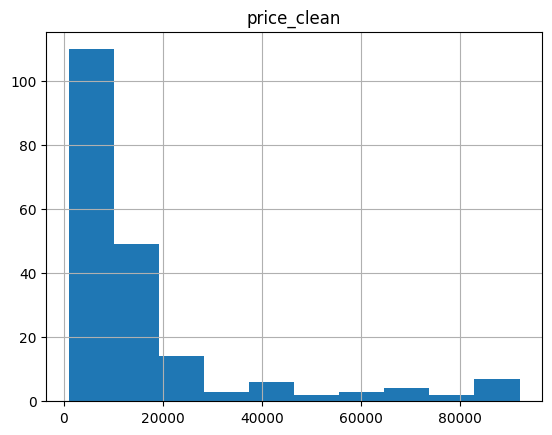

In [ ]:
# Cub price distribution
df_filter[df_filter["model"] == "Cub"][["price_clean"]].hist()

# There seems to be 2 variations
# - Popular variation with price around 15 mil
# - Current variation in production around 88 mil
# > Need variation detection

In [ ]:
# Vespa
# See model_ref_price_full.csv
# Wild difference in variation price
df_variants = pd.read_csv(MODEL_REF_PRICE_PATH)
df_variants["price_avg"] = (df_variants["price_min"] + df_variants["price_max"]) / 2
df_variants[df_variants["brand_name"] == "Vespa"][
    ["brand_name", "model_name", "price_min", "price_max", "price_avg"]
]

,brand_name,model_name,price_min,price_max,price_avg
30,Vespa,Primavera,76.8,110.0,93.40
31,Vespa,Sprint,103.8,119.8,111.80
32,Vespa,GTS Super,94.3,179.0,136.65
33,Vespa,Sei Giorni,139.4,139.4,139.40
34,Vespa,GTV,159.8,159.8,159.80
35,Vespa,946,460.0,460.0,460.00


### Remove weak predictors

In [ ]:
X3 = sm.add_constant(
    data=df_filter_2[
        [
            "age_log",
            "mileage_log",
            "origin_multiplier",
            "model_ref_price_log",
            # "province_scoli",
        ]
    ]
)
model_3 = sm.OLS(Y2, X3).fit()
print(f"{model_3.summary()=}")

model_3.summary()=<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     375.1
Date:                Thu, 17 Apr 2025   Prob (F-statistic):          3.52e-293
Time:                        16:30:12   Log-Likelihood:                -8566.5
No. Observations:                7024   AIC:                         1.714e+04
Df Residuals:                    7019   BIC:                         1.718e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

## 3.2.3. Final model diagnosis

### Retrain final model

In [ ]:
df_final = df_filter[~df_filter["model"].isin(["Vespa", "Cub", "R", "Dream"])]
# Recreate Y to have same index, or will output error
Y_final = df_final["price_log"]
X_final = sm.add_constant(
    data=df_final[
        [
            "age_log",
            "mileage_log",
            "origin_multiplier",
            "model_ref_price_log",
            # "province_scoli",
        ]
    ]
)

# Split train test data
X_final_train, X_final_test, Y_final_train, Y_final_test = train_test_split(
    X_final, Y_final, test_size=0.20, random_state=42
)

# Train model
lin_model = sm.OLS(Y_final_train, X_final_train).fit()

### Model diagnosis

#### Overall metrics

In [ ]:
# Summary
print(f"{lin_model.summary()=}")

# Prepare values for evaluation
Y_pred = lin_model.predict(X_final_test)
Y_pred_transformed = np.exp(Y_pred)
Y_test_transformed = np.exp(Y_final_test)

# Evaluation metrics
pred_mae = meanabs(Y_test_transformed, Y_pred_transformed)
pred_mse = mse(Y_test_transformed, Y_pred_transformed)
pred_rmse = rmse(Y_test_transformed, Y_pred_transformed)
r_squared = lin_model.rsquared
pred_mape = mean_absolute_percentage_error(
    y_true=Y_test_transformed, y_pred=Y_pred_transformed
)
print(f"{pred_mae=}")
print(f"{pred_mse=}")
print(f"{pred_rmse=}")
print(f"{r_squared=}")
print(f"{pred_mape * 100=: .2f}%")

lin_model.summary()=<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     305.6
Date:                Thu, 17 Apr 2025   Prob (F-statistic):          3.59e-238
Time:                        16:30:12   Log-Likelihood:                -6858.7
No. Observations:                5619   AIC:                         1.373e+04
Df Residuals:                    5614   BIC:                         1.376e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

NameError: name 'mean_absolute_percentage_error' is not defined

#### Residual plot

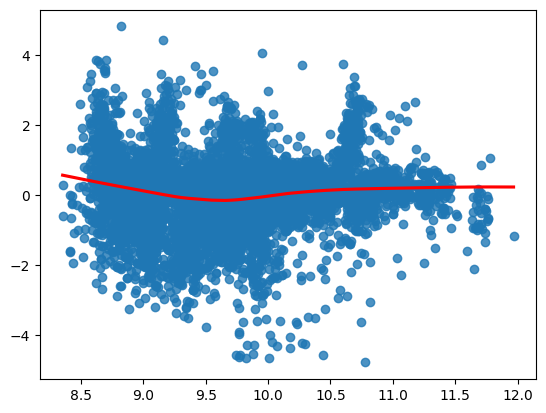

In [ ]:
sns.regplot(
    x=lin_model.fittedvalues,
    y=lin_model.get_influence().resid_studentized_internal,
    lowess=True,
    line_kws={"color": "red"},
)
plt.show()

In [ ]:
print(f"{round(np.exp(10.8)) * 1_000: ,}")

 49,021,000


#### Thử dùng mô hình đa thức với biến model_ref_price_log

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Polynomial for age_log
poly = PolynomialFeatures(degree=3)
model_ref_price_log_poly_intercept = poly.fit_transform(
    df_final[["model_ref_price_log"]]
)

# Polynomial regression with mileage
X_poly = np.hstack(
    (
        model_ref_price_log_poly_intercept,
        df_final[
            [
                "age_log",
                "mileage_log",
                "origin_multiplier",
                # "province_scoli",
            ]
        ],
    )
)
Y_poly = df_final["price_log"]

# Split train test data
X_poly_train, X_poly_test, Y_poly_train, Y_poly_test = train_test_split(
    X_poly, Y_poly, test_size=0.20, random_state=42
)
model_poly = sm.OLS(Y_poly_train, X_poly_train).fit()

In [ ]:
# Summary
print(f"{model_poly.summary()=}")

# Prepare values for evaluation
Y_pred = model_poly.predict(X_poly_test)
Y_pred_transformed = np.exp(Y_pred)
Y_test_transformed = np.exp(Y_poly_test)

# Evaluation metrics
pred_mae = meanabs(Y_test_transformed, Y_pred_transformed)
pred_mse = mse(Y_test_transformed, Y_pred_transformed)
pred_rmse = rmse(Y_test_transformed, Y_pred_transformed)
r_squared = model_poly.rsquared
pred_mape = mean_absolute_percentage_error(
    y_true=Y_test_transformed, y_pred=Y_pred_transformed
)
print(f"{pred_mae=}")
print(f"{pred_mse=}")
print(f"{pred_rmse=}")
print(f"{r_squared=}")
print(f"{pred_mape * 100=: .2f}%")

model_poly.summary()=<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     1772.
Date:                Wed, 16 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:17:48   Log-Likelihood:                -6313.0
No. Observations:                7417   AIC:                         1.264e+04
Df Residuals:                    7410   BIC:                         1.269e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

## 3.3. Mô hình Random Forest

## 3.4. So sánh hai mô hình (slide)